In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import evaluation.evaluate as evaluate
import matplotlib.pyplot as plt
import math_utils.matrix_utils as matrix_utils
import models.regression_models as reg_models
import models.PLDS as PLDS
import numpy as np
import os
import PGLDM.PGLDM as PGLDM
import PGLDM.SDP_optimize as SDP_optimize
import visualization.visualization as viz_utils

#### Utility methods

In [3]:
def extract_shared_disjoint(params, pgldm_params, sid_params):
  """Extracts shared and disjoint modes in primary and seconday observations to compare against learned modes."""
  shared_primary_inds = np.isin(params['rev_statesy'], params['rev_statesz'])
  shared_states = params['rev_statesy'][shared_primary_inds]
  shared_eigs = np.linalg.eigvals(matrix_utils.extract_block(params['A'], shared_states))

  private_primary_states = np.delete(params['rev_statesy'], shared_primary_inds)
  primary_only_eigs = np.linalg.eigvals(matrix_utils.extract_block(params['A'], private_primary_states))
  
  if 'eps_sysz' in params:
    secondary_only_eigs = np.linalg.eigvals(params['eps_sysz']['A'])
  else:
    shared_secondary_inds = np.isin(params['rev_statesz'], params['rev_statesy'])
    private_secondary_states = np.delete(params['rev_statesz'], shared_secondary_inds)
    secondary_only_eigs = np.linalg.eigvals(matrix_utils.extract_block(params['A'], private_secondary_states))

  pgldm_eigs = np.linalg.eigvals(pgldm_params['A'])
  sid_eigs = np.linalg.eigvals(sid_params['A'])
  return {
    'shared_eigs': shared_eigs, 'primary_only_eigs': primary_only_eigs, 'secondary_only_eigs': secondary_only_eigs,
    'pgldm_eigs': pgldm_eigs, 'sid_eigs': sid_eigs
  }


_TITLE_STR = lambda n1, nx: f'n1={n1},nx={nx}'
def plot_true_and_learned_eigeninfo(params, pgldm_params, sid_params, title, sid_variant='sid'):
  """Visualizes the identified modes by both learning algorithms vs groud truth modes."""
  extracted_eigen_info = extract_shared_disjoint(params, pgldm_params, sid_params)

  colors = { # Colors for visualizing the modes.
    'shared': '#39b54a', 'primary only': '#e5542c', 'secondary only': '#0071bd',
    'pgldm': '#39b54a', 'sid': '#e5542c'
  }

  viz_utils.plot_eigenvalues(
    [extracted_eigen_info['shared_eigs'], extracted_eigen_info['primary_only_eigs'],
     extracted_eigen_info['secondary_only_eigs'], extracted_eigen_info['pgldm_eigs'],
     extracted_eigen_info['sid_eigs']],
     title, labels=['shared', 'primary only', 'secondary only', 'pgldm', sid_variant],
     markers=['o', 'o', 'o', 'x', 'x'],
     edgecolors=[colors['shared'], colors['primary only'], colors['secondary only'], None, None],
     facecolors=['None', 'None', 'None', colors['pgldm'], colors['sid']],
     alpha_vals=[0.4, 0.4, 0.4, 0.8, 0.8],
     bound_lims_to_circle=False, show_legend=True, legend_location='upper left', fig=None, ax=None)
  plt.xlim([0.6, 1.0])
  plt.ylim([-0.35, 0.35])
  plt.show()

### Bernoulli-Gaussian system identification example

Here we demonstrate PGLDM's usage with joint Bernoulli-Gaussian observations as primary-secondary time-series. Using the first stage only, we learn a latent model corresponding to true shared dimensionality using both PGLDM and bestLDS (the appropriate single time-series SSID algorithm for Bernoulli observations). We then visualize the learned modes on a pole-zero diagram alongside the true shared vs private modes to qualitatively evaluate learning.

In [4]:
data = np.load(os.path.join(os.getcwd(), 'sample_data', 'sample_berngaus_sys.npz'), allow_pickle=True)

### Prepare the data.
Y, Z, params = data['Y'], data['Z'], data['params'][()]

num_train = int(Y.shape[0]/2)
Ytrain, Ztrain = Y[:num_train, :].astype('float64'), Z[:num_train, :]
Ytest, Ztest = Y[num_train:, :].astype('float64'), Z[num_train:, :]

##### Without loss of generality, demean the Gaussian observations.
Zmean = np.mean(Ztrain, axis=0, keepdims=True)
Ztrain -= Zmean
Ztest -= Zmean

In [5]:
n1 = nx = np.sum(np.isin(params['rev_statesz'], params['rev_statesy'])) # Shared dynamics dimensionality.
i = 10 # horizon

### PGLDM Stage 1 only.
pgldm_params = PGLDM.PGLDM(i, nx, Ytrain.T, PGLDM.ObservationType.BernGaus, T=Ztrain.T, n1=n1, T_horizon=i)

### bestLDS.
bestLDS_params = PGLDM.PGLDM(i, nx, Ytrain.T, PGLDM.ObservationType.SingleBernoulli, n1=0)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


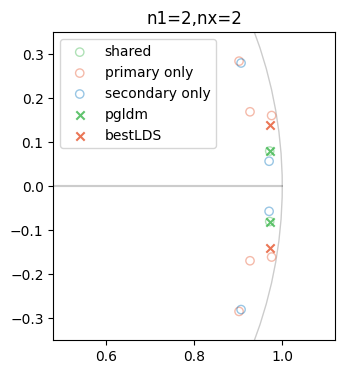

In [6]:
plot_true_and_learned_eigeninfo(params, pgldm_params, bestLDS_params, _TITLE_STR(n1, nx), sid_variant='bestLDS')

### Poisson-Poisson system identification example

Here we demonstrate PGLDM's usage with joint Poisson-Poisson observations as primary-secondary time-series. Using the first stage only, we learn a latent model corresponding to true shared dimensionality using both PGLDM and PLDSID (the appropriate single time-series SSID algorithm for Poisson observations). We then visualize the learned modes on a pole-zero diagram alongside the true shared vs private modes to qualitatively evaluate learning.

In [7]:
data = np.load(os.path.join(os.getcwd(), 'sample_data', 'sample_poispois_sys.npz'), allow_pickle=True)

### Prepare the data.
Y, T, params = data['Y'], data['T'], data['params'][()]

num_train = int(Y.shape[0]/2)
Ytrain, Ttrain = Y[:num_train, :].astype('float64'), T[:num_train, :]
Ytest, Ttest = Y[num_train:, :].astype('float64'), T[num_train:, :]

In [8]:
print(params['rev_statesz'], params['rev_statesy'])

[ 0  1  8  9 10 11] [0 1 2 3 4 5 6 7]


In [9]:
n1 = nx = np.sum(np.isin(params['rev_statesz'], params['rev_statesy'])) # Shared dynamics dimensionality.
i = 10 # horizon

### PGLDM Stage 1 only.
pgldm_params = PGLDM.PGLDM(i, nx, Ytrain.T, PGLDM.ObservationType.PoisPois, T=Ttrain.T, n1=n1, T_horizon=i)

### PLDSID.
pldsid_params = PGLDM.PGLDM(i, nx, Ytrain.T, PGLDM.ObservationType.SinglePoisson, n1=0)

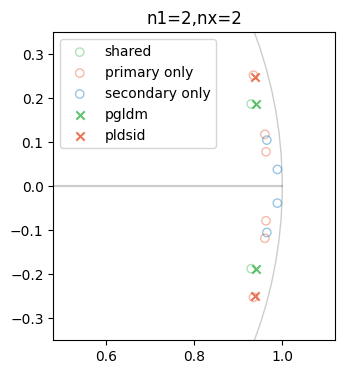

In [10]:
plot_true_and_learned_eigeninfo(params, pgldm_params, pldsid_params, _TITLE_STR(n1, nx), sid_variant='pldsid')

### Poisson-Gaussian system identification example

Here we demonstrate PGLDM's usage with joint Poisson-Gaussian observations as primary-secondary time-series. Using the first stage only, we learn a latent model corresponding to true shared dimensionality using both PGLDM and PLDSID (the appropriate single time-series SSID algorithm for Poisson observations). We then visualize the learned modes on a pole-zero diagram alongside the true shared vs private modes to qualitatively evaluate learning.

In [11]:
data = np.load(os.path.join(os.getcwd(), 'sample_data', 'sample_poisgaus_sys.npz'), allow_pickle=True)

### Prepare the data.
Y, Z, params = data['Y'], data['Z'], data['params'][()]

num_train = int(Y.shape[0]/2)
Ytrain, Ztrain = Y[:num_train, :].astype('float64'), Z[:num_train, :]
Ytest, Ztest = Y[num_train:, :].astype('float64'), Z[num_train:, :]

##### Without loss of generality, demean the Gaussian observations.
Zmean = np.mean(Ztrain, axis=0, keepdims=True)
Ztrain -= Zmean
Ztest -= Zmean

In [12]:
n1 = nx = np.sum(np.isin(params['rev_statesz'], params['rev_statesy'])) # Shared dynamics dimensionality.
i = 10 # horizon

### PGLDM Stage 1 only.
pgldm_params = PGLDM.PGLDM(i, nx, Ytrain.T, PGLDM.ObservationType.PoisGaus, T=Ztrain.T, n1=n1, T_horizon=i)

### PLDSID.
pldsid_params = PGLDM.PGLDM(i, nx, Ytrain.T, PGLDM.ObservationType.SinglePoisson, n1=0)

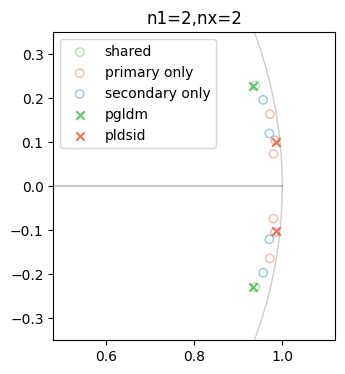

In [13]:
plot_true_and_learned_eigeninfo(params, pgldm_params, pldsid_params, _TITLE_STR(n1, nx), sid_variant='pldsid')

##### Stage 3 Demonstration

Using the same Poisson-Gaussian simulation, we now demonstrate usage of the optional 3rd state to learn the latents private to the secondary time series. Here we run all three stages, but stage 3 can be used without the inclusion of stage 2 (e.g., stage 1 + 3 only). After learning the private modes, we visualize them in a pole-zero diagram to visually inspect how well the private modes were learned.

In [14]:
n1 = np.sum(np.isin(params['rev_statesz'], params['rev_statesy']))
nx = len(params['rev_statesy'])
# Please refer to Appendix A.7.1 for how private latents x3 were simulated for Gaussian observations.
n3 = params['eps_sysz']['A'].shape[0]

i = 10 # horizon

### PGLDM Stage 1 + 2 + 3.
pgldm_params = PGLDM.PGLDM(i, nx, Ytrain.T, PGLDM.ObservationType.PoisGaus, T=Ztrain.T, n1=n1, T_horizon=i, n3=n3)

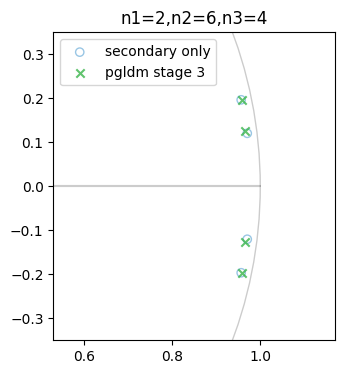

In [15]:
eigeninfo = extract_shared_disjoint(params, pgldm_params, pldsid_params)
pgldm_stage3_modes = np.linalg.eigvals(pgldm_params['secondary_private_params']['A'])

colors = {'secondary only': '#0071bd', 'pgldm': '#39b54a'}

viz_utils.plot_eigenvalues(
  [eigeninfo['secondary_only_eigs'], pgldm_stage3_modes],
  f'n1={n1},n2={nx-n1},n3={n3}', labels=['secondary only', 'pgldm stage 3'],
   markers=['o','x'],
   edgecolors=[colors['secondary only'], None],
   facecolors=['None', colors['pgldm']],
   alpha_vals=[0.4, 0.8],
   bound_lims_to_circle=False, show_legend=True, legend_location='upper left', fig=None, ax=None)
plt.xlim([0.7, 1.0])
plt.ylim([-0.35, 0.35])
plt.show()

### Demonstration of secondary time-series decoding and primary time-series self-prediction using the same system.

Using a different simulated Poisson-Gaussian system with more observations and larger difference between the numer of shared vs private primary states, we demonstrate PGLDM's ability to improve decoding performance due to the explicit modeling of shared dynamics.

In [16]:
data = np.load(os.path.join(os.getcwd(), 'sample_data', 'sample_sys.npz'), allow_pickle=True)

### Prepare the data.
Y, Z, params = data['Y'], data['Z'], data['params'][()]

num_train = int(Y.shape[0]/2)
Ytrain, Ztrain = Y[:num_train, :].astype('float64'), Z[:num_train, :]
Ytest, Ztest = Y[num_train:, :].astype('float64'), Z[num_train:, :]

##### Without loss of generality, demean the Gaussian observations.
Zmean = np.mean(Ztrain, axis=0, keepdims=True)
Ztrain -= Zmean
Ztest -= Zmean

In [17]:
n1 = nx = np.sum(np.isin(params['rev_statesz'], params['rev_statesy'])) # Shared dynamics dimensionality.
i = 10 # horizon

### PGLDM Stage 1 only.
pgldm_params = PGLDM.PGLDM(i, nx, Ytrain.T, PGLDM.ObservationType.PoisGaus, T=Ztrain.T, n1=n1, T_horizon=i)

### PLDSID.
pldsid_params = PGLDM.PGLDM(i, nx, Ytrain.T, PGLDM.ObservationType.SinglePoisson, n1=0)

## Use convex optimization (Appendix A.3) to compute noise covariances necessary to construct the point-process
## filter (Eden & Brown, 2008).
pgldm_params = SDP_optimize.optimize(pgldm_params)
pldsid_params = SDP_optimize.optimize(pldsid_params)

The optimal value is 46.35446703999908 with status: optimal
The optimal value is 6.152844128904781 with status: optimal


In [18]:
### NOTE: This block will take some time to run as we're testing on 1e6 contiguous samples and the point-process
### filter runs recursively.

#### PLDS model using PGLDM parameters.
pgldm_sys = PLDS.update_missing_params_and_construct_PLDS(pgldm_params)

### Predict the test data.
other_out = {'Z': pgldm_params['Cz']}
pgldm_y_pred, _, other_est = pgldm_sys.predict(Ytest, other_out)
pgldm_z_pred = other_est['Z']

pgldm_z_evalres = evaluate.evaluate_results(Ztest, pgldm_z_pred, ['CC'])['CC']

#### Handle prediction covariances to compute AUC.
Pp = other_est.get('Pp', None) # Prediction error covariance.
assert (Pp is not None)
log_rate_covariances = Pp @ pgldm_params['C'].T # (time, nx, nr)
log_rate_covariances = np.transpose(log_rate_covariances, (0, 2, 1)) @ pgldm_params['C'].T # (time, nr, nr)
pgldm_y_evalres = evaluate.evaluate_results(
                      Ytest, pgldm_y_pred, ['AUC'], predicted_covariances=log_rate_covariances)['AUC']

In [19]:
#### PLDS model using PLDSID parameters.
pldsid_sys = PLDS.update_missing_params_and_construct_PLDS(pldsid_params)

##### First fit Cz.
_, x_pred, _ = pldsid_sys.predict(Ytrain, {}) # Predict xTrain.
reg_kwargs = {'fit_intercept': True}
regression = reg_models.RegressionModel(reg_models.RegressionMethod.OLS_REG)
## Must be (num_samples, num_features)
regression.fit(x_pred, Ztrain, **reg_kwargs) # Regress training data onto the estimated latent states.
reg_weights, reg_intercept = regression.weights()
pldsid_params['Cz'] = reg_weights

##### Now predict test data.
other_out = {'Z': pldsid_params['Cz']}
pldsid_y_pred, _, other_est = pldsid_sys.predict(Ytest, other_out)
pldsid_z_pred = other_est['Z']

pldsid_z_evalres = evaluate.evaluate_results(Ztest, pldsid_z_pred, ['CC'])['CC']

#### Handle prediction covariances to compute AUC.
Pp = other_est.get('Pp', None) # Prediction error covariance.
assert (Pp is not None)
log_rate_covariances = Pp @ pldsid_params['C'].T # (time, nx, nr)
log_rate_covariances = np.transpose(log_rate_covariances, (0, 2, 1)) @ pldsid_params['C'].T # (time, nr, nr)
pldsid_y_evalres = evaluate.evaluate_results(
                    Ytest, pldsid_y_pred, ['AUC'], predicted_covariances=log_rate_covariances)['AUC']

In [20]:
print(f'PGLDM Z prediction CC {pgldm_z_evalres.mean()}, PLDSID Z prediction CC {pldsid_z_evalres.mean()}')
print(f'PGLDM Y prediction AUC {pgldm_y_evalres.mean()}, PLDSID Y prediction AUC {pldsid_y_evalres.mean()}')

PGLDM Z prediction CC 0.46216264610683616, PLDSID Z prediction CC 0.40961546633248686
PGLDM Y prediction AUC 0.5447589112937984, PLDSID Y prediction AUC 0.5592364736580343


##### Next, we demonstrate decoding and self-prediction performance when including stage 2 to model the private dynamics in the primary time-series.

In [21]:
n1 = np.sum(np.isin(params['rev_statesz'], params['rev_statesy']))
nx = len(params['rev_statesy'])
i = 10 # horizon

# PGDLM Stage 1 + 2.
pgldm_params = PGLDM.PGLDM(i, nx, Ytrain.T, PGLDM.ObservationType.PoisGaus, T=Ztrain.T, n1=n1, T_horizon=i)
pgldm_params = SDP_optimize.optimize(pgldm_params)

# PLDSID.
pldsid_params = PGLDM.PGLDM(i, nx, Ytrain.T, PGLDM.ObservationType.SinglePoisson, n1=0)
pldsid_params = SDP_optimize.optimize(pldsid_params)

The optimal value is 6.034638926763588 with status: optimal
The optimal value is 2.5482397391823426 with status: optimal


In [22]:
### NOTE: This block will take some time to run as we're testing on 1e6 contiguous amples and the point-process
### filter runs recursively.

#### PLDS model using PGLDM parameters.
pgldm_sys = PLDS.update_missing_params_and_construct_PLDS(pgldm_params)

#### Predict test data.
other_out = {'Z': pgldm_params['Cz']}
pgldm_y_pred, _, other_est = pgldm_sys.predict(Ytest, other_out)
pgldm_z_pred = other_est['Z']

pgldm_z_evalres = evaluate.evaluate_results(Ztest, pgldm_z_pred, ['CC'])['CC']

#### Handle prediction covariances to compute AUC.
Pp = other_est.get('Pp', None) # Prediction error covariance.
assert (Pp is not None)
log_rate_covariances = Pp @ pgldm_params['C'].T # (time, nx, nr)
log_rate_covariances = np.transpose(log_rate_covariances, (0, 2, 1)) @ pgldm_params['C'].T # (time, nr, nr)
pgldm_y_evalres = evaluate.evaluate_results(
                      Ytest, pgldm_y_pred, ['AUC'], predicted_covariances=log_rate_covariances)['AUC']

In [23]:
#### PLDS model using PLDSID parameters.
pldsid_sys = PLDS.update_missing_params_and_construct_PLDS(pldsid_params)

##### First fit Cz.
_, x_pred, _ = pldsid_sys.predict(Ytrain, {}) # Predict xTrain.
reg_kwargs = {'fit_intercept': True}
regression = reg_models.RegressionModel(reg_models.RegressionMethod.OLS_REG)
## Must be (num_samples, num_features)
regression.fit(x_pred, Ztrain, **reg_kwargs) # Regress observations onto estimated latents.
reg_weights, reg_intercept = regression.weights()
pldsid_params['Cz'] = reg_weights

##### Now predict test data.
other_out = {'Z': pldsid_params['Cz']}
pldsid_y_pred, _, other_est = pldsid_sys.predict(Ytest, other_out)
pldsid_z_pred = other_est['Z']

pldsid_z_evalres = evaluate.evaluate_results(Ztest, pldsid_z_pred, ['CC'])['CC']

#### Handle prediction covariances to compute AUC.
Pp = other_est.get('Pp', None) # Prediction error covariance.
assert (Pp is not None)
log_rate_covariances = Pp @ pldsid_params['C'].T # (time, nx, nr)
log_rate_covariances = np.transpose(log_rate_covariances, (0, 2, 1)) @ pldsid_params['C'].T # (time, nr, nr)
pldsid_y_evalres = evaluate.evaluate_results(
                    Ytest, pldsid_y_pred, ['AUC'], predicted_covariances=log_rate_covariances)['AUC']

In [24]:
print(f'PGLDM Z prediction CC {pgldm_z_evalres.mean()}, PLDSID Z prediction CC {pldsid_z_evalres.mean()}')
print(f'PGLDM Y prediction AUC {pgldm_y_evalres.mean()}, PLDSID Y prediction AUC {pldsid_y_evalres.mean()}')

PGLDM Z prediction CC 0.4773237849353172, PLDSID Z prediction CC 0.47613448679244974
PGLDM Y prediction AUC 0.5711734082729463, PLDSID Y prediction AUC 0.5711118238927165
